In [47]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Flatten, LSTM,Dropout,Conv2D,TimeDistributed
from tensorflow.keras.models import Sequential

In [48]:
eeg=np.load('D:/lab_work_25/AUG/HYBRID EEG EMG/Processed_Data/sub2/sample_eeg.npy')
eeg = eeg[:, 200:875, :]/4
emg=np.load('D:/lab_work_25/AUG/HYBRID EEG EMG/Processed_Data/sub2/sample_emg.npy')
emg=np.moveaxis(emg, 1, 2) 
emg = emg[:, 200:875, :]
kinematic=np.load('D:/lab_work_25/AUG/HYBRID EEG EMG/Processed_Data/sub2/sample_kin.npy')
 
kinematic=np.moveaxis(kinematic, 1, 2)
kinematic = kinematic[:, 200:875, :]
print(eeg.shape, emg.shape, kinematic.shape)

(34, 675, 21) (34, 675, 5) (34, 675, 3)


In [49]:
import tensorflow as tf
import numpy as np

# --- Symmetric, zero-diagonal initializer ---
def symmetric_zero_diag_glorot(shape, dtype=None):
    W = tf.keras.initializers.GlorotUniform()(shape, dtype=dtype)
    W_sym = 0.5 * (W + tf.transpose(W))
    W_zero_diag = tf.linalg.set_diag(W_sym, tf.zeros(shape[0], dtype=dtype))
    return W_zero_diag

def symmetrize_and_zero_diag(W):
    W_sym = 0.5 * (W + tf.transpose(W))
    dim = tf.shape(W_sym)[0]
    diag = tf.zeros([dim], dtype=W_sym.dtype)
    return tf.linalg.set_diag(W_sym, diag)

# --- Kuramoto Layer ---
class Kuramoto(tf.keras.layers.Layer):
    def __init__(self, units, num_steps=675, dt=1/100,
                 min_omega=0.1, max_omega=30.0, hebb_lr=0.001, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.num_steps = num_steps
        self.dt = dt
        self.min_omega = min_omega
        self.max_omega = max_omega
        self.hebb_lr = hebb_lr

    def build(self, input_shape):
        self.omega = self.add_weight(
            shape=(self.units,),
            initializer="uniform",
            trainable=True,
            constraint=lambda x: tf.clip_by_value(x, self.min_omega, self.max_omega),
            name="omega"
        )
        self.W = self.add_weight(
            shape=(self.units, self.units),
            initializer=symmetric_zero_diag_glorot,
            trainable=True,
            name="W"
        )

    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]
        omegas = tf.expand_dims(self.omega, 0)  # (1, units)
        phis = tf.zeros((batch_size, self.units))


        # Convert input to TensorArray (time-major)
        inputs_ta = tf.TensorArray(dtype=tf.float32, size=self.num_steps)
        inputs_ta = inputs_ta.unstack(tf.transpose(inputs, perm=[1, 0, 2]))

        phi_arr = tf.TensorArray(dtype=tf.float32, size=self.num_steps)
        t0 = tf.constant(0)

        def cond(t, phis, W, phi_arr):
            return t < self.num_steps

        def body(t, phis, W, phi_arr):
            inp_t = inputs_ta.read(t)
            input_phi = 4 * inp_t

            diff = tf.expand_dims(phis, 2) - tf.expand_dims(phis, 1)
            coupling = 1e-4 * tf.reduce_sum(tf.expand_dims(W, 0) * tf.sin(diff), axis=-1)

            phis = phis + (omegas + input_phi + coupling) * self.dt
            phis = tf.math.floormod(phis, 2 * np.pi)

            phi_arr = phi_arr.write(t, phis)

            def update_W():
                cos_diff = tf.math.cos(diff)
                delta_W_batch_mean = tf.reduce_mean(cos_diff, axis=0)
                delta_W = self.hebb_lr * delta_W_batch_mean / tf.cast(self.units, tf.float32)
                newW = symmetrize_and_zero_diag(W + delta_W)
                return tf.clip_by_value(newW, -1.0, 1.0)

            W = tf.cond(tf.cast(training, tf.bool), update_W, lambda: W)
            return t + 1, phis, W, phi_arr

        _, _, _, phi_arr_final = tf.while_loop(
            cond, body,
            loop_vars=[t0, phis, self.W, phi_arr],
            shape_invariants=[
                t0.get_shape(),
                tf.TensorShape([None, self.units]),
                tf.TensorShape([self.units, self.units]),
                tf.TensorShape(None)  # Let TF infer TensorArray shape dynamically
            ]
        )

        phi_arr_final = tf.transpose(phi_arr_final.stack(), perm=[1, 0, 2])
        phi_arr_final.set_shape([None, self.num_steps, self.units])
        return tf.math.cos(phi_arr_final), tf.math.sin(phi_arr_final)

# --- Parallel Kuramoto Model ---
class ParallelKuramotoModel(tf.keras.Model):
    def __init__(self, input_dim_A, input_dim_B, units1, units2,units6, output_dim):
        super().__init__()
        # Input projections
        self.project_A = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units1, activation='relu'))
        self.project_B = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units2, activation='relu'))

        # Kuramoto layers
        self.kuramoto_A = Kuramoto(units1)
        self.kuramoto_B = Kuramoto(units2)

        # Embeddings for cos/sin
        self.embed_A_r = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units1, activation='relu'))
        self.embed_A_i = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units1, activation='relu'))
        self.embed_B_r = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units2, activation='relu'))
        self.embed_B_i = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units2, activation='relu'))

        # Dense processing
        self.dense_A = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10, activation="tanh"))
        self.dense_B = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10, activation="tanh"))

        # Output
        self.merge_tanh = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units6, activation='tanh'))
        self.out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(output_dim, activation="linear"))

    def call(self, inputs, training=False):
        if isinstance(inputs, (list, tuple)):
            X_A, X_B = inputs
            print("Input A shape:", X_A.shape)
            print("Input B shape:", X_B.shape)
        else:
            raise ValueError("Expected input as [X_A, X_B]")

        X_A_proj = self.project_A(X_A)
        X_B_proj = self.project_B(X_B)
        print("Projected A shape:", X_A_proj.shape)
        print("Projected B shape:", X_B_proj.shape)

        cos_A, sin_A = self.kuramoto_A(X_A_proj, training=training)
        cos_B, sin_B = self.kuramoto_B(X_B_proj, training=training)
        print("Cosine A shape:", cos_A.shape)
        print("Sine A shape:", sin_A.shape)
        print("Cosine B shape:", cos_B.shape)
        print("Sine B shape:", sin_B.shape)

        hA_r = self.embed_A_r(cos_A)
        hA_i = self.embed_A_i(sin_A)
        hB_r = self.embed_B_r(cos_B)
        hB_i = self.embed_B_i(sin_B)
        print("Embedded A (real) shape:", hA_r.shape)
        print("Embedded A (imag) shape:", hA_i.shape)
        print("Embedded B (real) shape:", hB_r.shape)
        print("Embedded B (imag) shape:", hB_i.shape)

        hA = tf.concat([hA_r, hA_i], axis=-1)
        hB = tf.concat([hB_r, hB_i], axis=-1)
        print("Concatenated A shape:", hA.shape)
        print("Concatenated B shape:", hB.shape)

        hA = self.dense_A(hA)
        hB = self.dense_B(hB)
        print("Dense A shape:", hA.shape)
        print("Dense B shape:", hB.shape)

        concat = tf.concat([hA, hB], axis=-1)
        print("Concatenated shape:", concat.shape)
        merged_tanh = self.merge_tanh(concat)
        print("Merged tanh shape:", merged_tanh.shape)
        out = self.out(merged_tanh)
        print("Output shape:", out.shape)
        return out

# --- Demo Run with Toy Data ---
'''tf.random.set_seed(42)
np.random.seed(42)

BATCH_SIZE = 8
TIMESTEPS = 725
FEATURE_DIM_A = 21
FEATURE_DIM_B = 5
OUTPUT_DIM = 3

X_A = np.random.randn(BATCH_SIZE, TIMESTEPS, FEATURE_DIM_A).astype(np.float32)
X_B = np.random.randn(BATCH_SIZE, TIMESTEPS, FEATURE_DIM_B).astype(np.float32)
y = np.random.randn(BATCH_SIZE, TIMESTEPS, OUTPUT_DIM).astype(np.float32)

model = ParallelKuramotoModel(
    input_dim_A=FEATURE_DIM_A,
    input_dim_B=FEATURE_DIM_B,
    units1=16,
    units2=12,
    output_dim=OUTPUT_DIM
)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
history = model.fit([X_A, X_B], y, epochs=50, batch_size=4)'''


'tf.random.set_seed(42)\nnp.random.seed(42)\n\nBATCH_SIZE = 8\nTIMESTEPS = 725\nFEATURE_DIM_A = 21\nFEATURE_DIM_B = 5\nOUTPUT_DIM = 3\n\nX_A = np.random.randn(BATCH_SIZE, TIMESTEPS, FEATURE_DIM_A).astype(np.float32)\nX_B = np.random.randn(BATCH_SIZE, TIMESTEPS, FEATURE_DIM_B).astype(np.float32)\ny = np.random.randn(BATCH_SIZE, TIMESTEPS, OUTPUT_DIM).astype(np.float32)\n\nmodel = ParallelKuramotoModel(\n    input_dim_A=FEATURE_DIM_A,\n    input_dim_B=FEATURE_DIM_B,\n    units1=16,\n    units2=12,\n    output_dim=OUTPUT_DIM\n)\n\nmodel.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")\nhistory = model.fit([X_A, X_B], y, epochs=50, batch_size=4)'

In [50]:
eeg_trn=eeg[:30, :, :]
emg_trn=emg[:30, :, :]
kinematic_trn=kinematic[:30, :, :]
print(eeg_trn.shape, emg_trn.shape, kinematic_trn.shape)
eeg_test=eeg[30:, :, :]
emg_test=emg[30:, :, :]
kinematic_test=kinematic[30:, :, :]
print(eeg_test.shape, emg_test.shape, kinematic_test.shape)

(30, 675, 21) (30, 675, 5) (30, 675, 3)
(4, 675, 21) (4, 675, 5) (4, 675, 3)


In [51]:
BATCH_SIZE = 6
TIMESTEPS = 675
FEATURE_DIM_A = 21
FEATURE_DIM_B = 5
OUTPUT_DIM = 3

model = ParallelKuramotoModel(
    input_dim_A=FEATURE_DIM_A,
    input_dim_B=FEATURE_DIM_B,
    units1=50,
    units2=50,
    units6=5,
    output_dim=OUTPUT_DIM
)


In [52]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',      # regression-like output
    metrics=['mae']
)

# Callback to save the best weights
checkpoint = ModelCheckpoint(
    filepath='D:/lab_work_25/AUG/HYBRID EEG EMG/Processed_Data/sub2/best_model_weights.h5',   # save only weights
    monitor='val_loss',                 # monitor validation loss
    save_best_only=True,                # save only the best
    save_weights_only=True,             # save only weights, not full model
    mode='min',
    verbose=1
)

# Train
history = model.fit(
    [eeg_trn, emg_trn], kinematic_trn,
    batch_size=BATCH_SIZE,
    epochs=500,
    validation_split=0.2,
    callbacks=[checkpoint]
)


Epoch 1/500
Input A shape: (6, 675, 21)
Input B shape: (6, 675, 5)
Projected A shape: (6, 675, 50)
Projected B shape: (6, 675, 50)
Cosine A shape: (6, 675, 50)
Sine A shape: (6, 675, 50)
Cosine B shape: (6, 675, 50)
Sine B shape: (6, 675, 50)
Embedded A (real) shape: (6, 675, 50)
Embedded A (imag) shape: (6, 675, 50)
Embedded B (real) shape: (6, 675, 50)
Embedded B (imag) shape: (6, 675, 50)
Concatenated A shape: (6, 675, 100)
Concatenated B shape: (6, 675, 100)
Dense A shape: (6, 675, 10)
Dense B shape: (6, 675, 10)
Concatenated shape: (6, 675, 20)
Merged tanh shape: (6, 675, 5)
Output shape: (6, 675, 3)
Input A shape: (6, 675, 21)
Input B shape: (6, 675, 5)
Projected A shape: (6, 675, 50)
Projected B shape: (6, 675, 50)
Cosine A shape: (6, 675, 50)
Sine A shape: (6, 675, 50)
Cosine B shape: (6, 675, 50)
Sine B shape: (6, 675, 50)
Embedded A (real) shape: (6, 675, 50)
Embedded A (imag) shape: (6, 675, 50)
Embedded B (real) shape: (6, 675, 50)
Embedded B (imag) shape: (6, 675, 50)
Conc

In [60]:
model.load_weights('D:/lab_work_25/AUG/HYBRID EEG EMG/Processed_Data/sub2/best_model_weights.h5')


In [61]:
y_pred=model.predict([eeg_test, emg_test], batch_size=BATCH_SIZE)

1/1 [==============================] - 0s 70ms/step


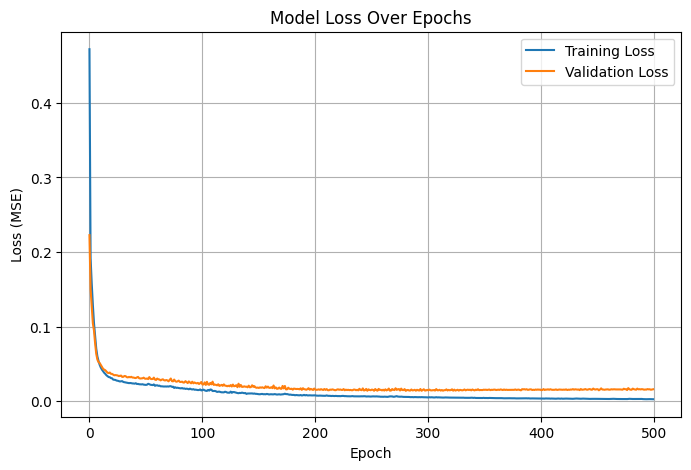

In [62]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
y_pred.shape

(4, 675, 3)

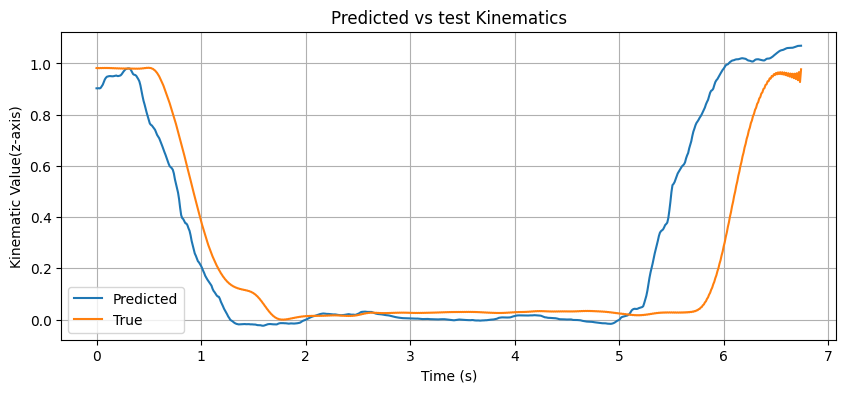

In [63]:
import matplotlib.pyplot as plt

# Example: sampling rate in Hz
fs = 100  # 100 samples per second
time_points = y_pred.shape[1]

# Convert indices to time in seconds
time = [t/fs for t in range(time_points)]

plt.figure(figsize=(10,4))
plt.plot(time, y_pred[0, :, 1], label='Predicted')
plt.plot(time, kinematic_test[0, :, 1], label='True')
plt.xlabel('Time (s)')
plt.ylabel('Kinematic Value(z-axis)')
plt.title('Predicted vs test Kinematics')
plt.legend()
plt.grid(True)
plt.show()


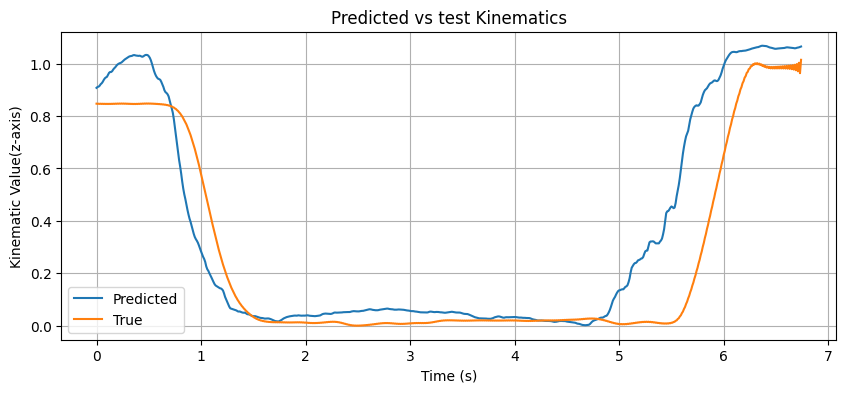

In [64]:
import matplotlib.pyplot as plt

# Example: sampling rate in Hz
fs = 100  # 100 samples per second
time_points = y_pred.shape[1]

# Convert indices to time in seconds
time = [t/fs for t in range(time_points)]

plt.figure(figsize=(10,4))
plt.plot(time, y_pred[2, :, 1], label='Predicted')
plt.plot(time, kinematic_test[2, :, 1], label='True')
plt.xlabel('Time (s)')
plt.ylabel('Kinematic Value(z-axis)')
plt.title('Predicted vs test Kinematics')
plt.legend()
plt.grid(True)
plt.show()


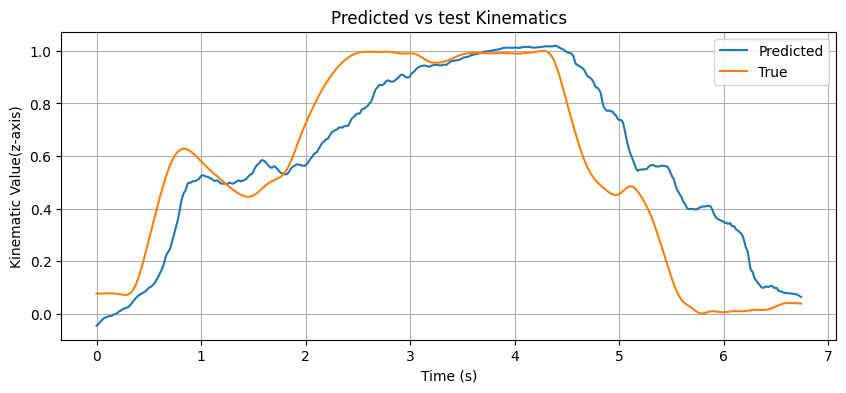

In [66]:
plt.figure(figsize=(10,4))
plt.plot(time, y_pred[3, :, 2], label='Predicted')
plt.plot(time, kinematic_test[3, :, 2], label='True')
plt.xlabel('Time (s)')
plt.ylabel('Kinematic Value(z-axis)')
plt.title('Predicted vs test Kinematics')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
import numpy as np
from scipy.stats import pearsonr

# y_pred: (8, 725, 3), kinematic_test: (8, 725, 3)
num_samples, num_timepoints, num_channels = y_pred.shape

rmse_all = np.zeros(num_channels)
pearson_all = np.zeros(num_channels)

for ch in range(num_channels):
    # Flatten across all samples and time points
    y_true_flat = kinematic_test[:, :, ch].flatten()
    y_pred_flat = y_pred[:, :, ch].flatten()
    
    # RMSE
    rmse = np.sqrt(np.mean((y_true_flat - y_pred_flat)**2))
    rmse_all[ch] = rmse
    
    # Pearson correlation
    corr, _ = pearsonr(y_true_flat, y_pred_flat)
    pearson_all[ch] = corr

axes = ['X', 'Y', 'Z']
for ch in range(num_channels):
    print(f"{axes[ch]} axis -> RMSE: {rmse_all[ch]:.4f}, Pearson r: {pearson_all[ch]:.4f}")


X axis -> RMSE: 0.1942, Pearson r: 0.8659
Y axis -> RMSE: 0.1975, Pearson r: 0.8671
Z axis -> RMSE: 0.1870, Pearson r: 0.8590
